## Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/colab/

/content/drive/MyDrive/colab


In [3]:
!pwd

/content/drive/MyDrive/colab


Deleted some unnecessary code blocks as I am importing from the given python files.

## save_load

In [4]:
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
from functools import partial
!pip install faker
from dataset import Dataset, transform, collate_fn
from model import Transformer
import save_load as sl


In [6]:
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
from functools import partial
#!pip install faker
from dataset import Dataset, transform, collate_fn
from model import Transformer
import save_load as sl

def calc_accuracy(pred, answer):
    # print(pred)
    pred = np.argmax(pred, axis=2)
    answer = np.argmax(answer, axis=2)
    # print(pred.shape, answer.shape)
    correct = (pred == answer).astype(np.int32)
    accuracy = correct.sum() / (pred.shape[0] * pred.shape[1])
    # print(accuracy)
    return accuracy

def train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=False):
    pbar = tqdm(total=len(dataloader), bar_format='{l_bar}{r_bar}', dynamic_ncols=True)
    pbar.set_description(f'Epoch %d' % epoch)

    for step, (batch_x, batch_y, _) in enumerate(dataloader):
        if use_gpu:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        pred = model(batch_x, batch_y[:, :-1, :])
        accuracy = calc_accuracy(pred.detach().cpu().numpy(), batch_y[:, 1:, :].detach().cpu().numpy())
        # loss = loss_fn(pred.transpose(1, 2), batch_y)
        loss = loss_fn(pred, batch_y[:, 1:, :])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(**{'loss':loss.detach().cpu().item(), 'accuracy':accuracy})
        pbar.update()
    sl.save_checkpoint('/content/drive/MyDrive/colab/model_folder', epoch, model, optimizer)

    pbar.close()

def main(gpu_id=None):
    dataset = Dataset(transform=transform, n_datas=10000)
    pad_vec = np.zeros(len(dataset.human_vocab))
    pad_vec[dataset.human_vocab['<pad>']] = 1
    dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=6,
                                            shuffle=True,
                                            num_workers=6,
                                            collate_fn=partial(collate_fn, pad_vec))

    model = Transformer(n_head=2)
    if gpu_id is not None:
        print('use gpu')
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
        n_gpus = torch.cuda.device_count()
        # print('use %d gpu [%s]' % (n_gpus, gpu_id))
        model = model.cuda()
        # model = torch.nn.DataParallel(model, device_ids=[i for i in range(n_gpus)])
    # loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters())

    model = sl.load_model('/content/drive/MyDrive/colab/model_folder', -1, model)
    optimizer = sl.load_optimizer('/content/drive/MyDrive/colab/model_folder', -1, optimizer)

    try:
        trained_epoch = sl.find_last_checkpoint('/content/drive/MyDrive/colab/model_folder')
        print("trained epoch", trained_epoch)
        print('train form epoch %d' % (trained_epoch + 1))
    except Exception as e:
        print('train from the very begining, {}'.format(e))
        trained_epoch = -1
    for epoch in range(trained_epoch, 20):
        train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=True if gpu_id is not None else False)

if __name__ == '__main__':
    if len(sys.argv) == 1:
        main(gpu_id=None)
    else:
        main(gpu_id='0')

100%|██████████| 10000/10000 [00:00<00:00, 27793.82it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


use gpu
trained epoch 19
train form epoch 20


Epoch 19:   0%|| 0/1667 [00:00<?, ?it/s]/content/drive/MyDrive/colab/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch_x = torch.FloatTensor(batch_x_paded)
/content/drive/MyDrive/colab/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch_x = torch.FloatTensor(batch_x_paded)
/content/drive/MyDrive/colab/dataset.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../to

import matplotlib.pyplot as plt line is not available added

100%|██████████| 10000/10000 [00:00<00:00, 27784.70it/s]


load model 19
[8/23/81] --> [2011-08-23<pad><pad><pad><pad>], answer: [['1', '9', '8', '1', '-', '0', '8', '-', '2', '3']]


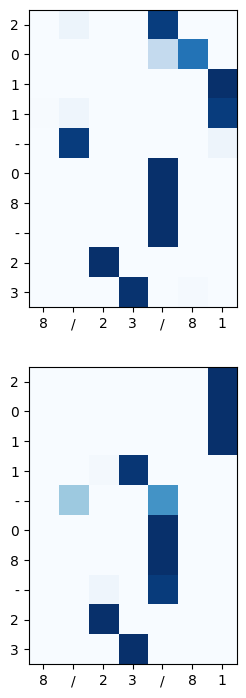

In [10]:
import matplotlib.pyplot as plt
def translate(model, x, y0):
    x_tensor = torch.from_numpy(x).unsqueeze(0)
    enc_output = model.encoder(x_tensor)
    y0_tensor = torch.from_numpy(y0).unsqueeze(0).unsqueeze(0)
    y_tensor = y0_tensor.clone()

    for step in range(14):
        dec_output = model.decoder(enc_output, y_tensor)
        pred = model.linear(dec_output)
        pred = torch.nn.Softmax(dim=-1)(pred)

        y_tensor = torch.cat((y0_tensor, pred), dim=1)
        # print(y_tensor.shape)
    return y_tensor.squeeze(0)

def paint_score(score, human_readable, pred):
    '''
    score: (n_head, T_dec, T_enc)
    human_readabe: string, length is T_enc
    pred: string, length is T_dec
    '''
    # print(score.shape, len(pred), len(human_readable))
    # print(pred, human_readable)

    n_head = score.shape[0]

    f = plt.figure(figsize=(8, 8.5))
    for i in range(n_head):
        ax = f.add_subplot(n_head, 1, i+1)
        i = ax.imshow(score[i, :10, :], interpolation='nearest', cmap='Blues')

        ax.set_xticks(range(min(30, len(human_readable))))
        ax.set_xticklabels(human_readable[:30], rotation=0)

        #ax.set_xticks(range(30))
        #ax.set_xticklabels(human_readable[:30], rotation=0)

        ax.set_yticks(range(10))
        ax.set_yticklabels(pred[:10], rotation=0)

    plt.savefig('./attention.png')

def main():
    dataset = Dataset(transform=transform, n_datas=10000, seed=None)
    model = Transformer(n_head=2)
    try:
        trained_epoch = sl.find_last_checkpoint('/content/drive/MyDrive/colab/model_folder')
        print('load model %d' % (trained_epoch))
    except Exception as e:
        print('no trained model found, {}'.format(e))
        return
    model = sl.load_model('/content/drive/MyDrive/colab/model_folder', -1, model)
    model.eval()

    x, y, extra = dataset.__getitem__(0)
    # print(x.shape, y.shape)
    # pred = model(torch.from_numpy(x).unsqueeze(0), torch.from_numpy(y).unsqueeze(0)).squeeze()
    pred = translate(model, x, y[0])
    # print(pred.shape)
    pred = np.argmax(pred.detach().numpy(), axis=1)[1:]
    # print(extra['machine_readable'])
    pred = [dataset.inv_machine_vocab[p] for p in pred]
    pred_str = ''.join(pred)
    human_readable = extra['human_readable']
    machine_readable = extra['machine_readable']
    print('[%s] --> [%s], answer: [%s]' % (human_readable, pred_str, list(machine_readable)))

    dec_scores = model.decoder.scores_for_paint
    # print(dec_scores.shape)
    paint_score(dec_scores[0], human_readable, pred)

    # print(len(model.scores_for_paint), model.scores_for_paint[0].shape)
    # scores = np.array(model.scores_for_paint)
    # print(np.argmax(scores, axis=1))

    # f = plt.figure(figsize=(8, 8.5))
    # ax = f.add_subplot(1, 1, 1)
    # i = ax.imshow(scores, interpolation='nearest', cmap='Blues')

    # ax.set_xticks(range(30))
    # ax.set_xticklabels(human_readable[:30], rotation=0)

    # ax.set_yticks(range(10))
    # ax.set_yticklabels(machine_readable[:10], rotation=0)

    # plt.savefig('./attention.png')

if __name__ == '__main__':
    main()